In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
#Carga y pre procesamiento de imagenes

batch_size = 32
img_height = 180
img_width = 180

train_df = tf.keras.utils.image_dataset_from_directory(
  "train",
  #validation_split=0.2,
  #subset="training",
  #seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_df = tf.keras.utils.image_dataset_from_directory(
  "test",
  #validation_split=0.2,
  #subset="training",
  #seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_df.class_names
print(class_names)


Found 1633 files belonging to 7 classes.
Found 809 files belonging to 7 classes.
['CLASS_02', 'CLASS_03', 'CLASS_04', 'CLASS_05', 'CLASS_06', 'CLASS_07', 'CLASS_08']


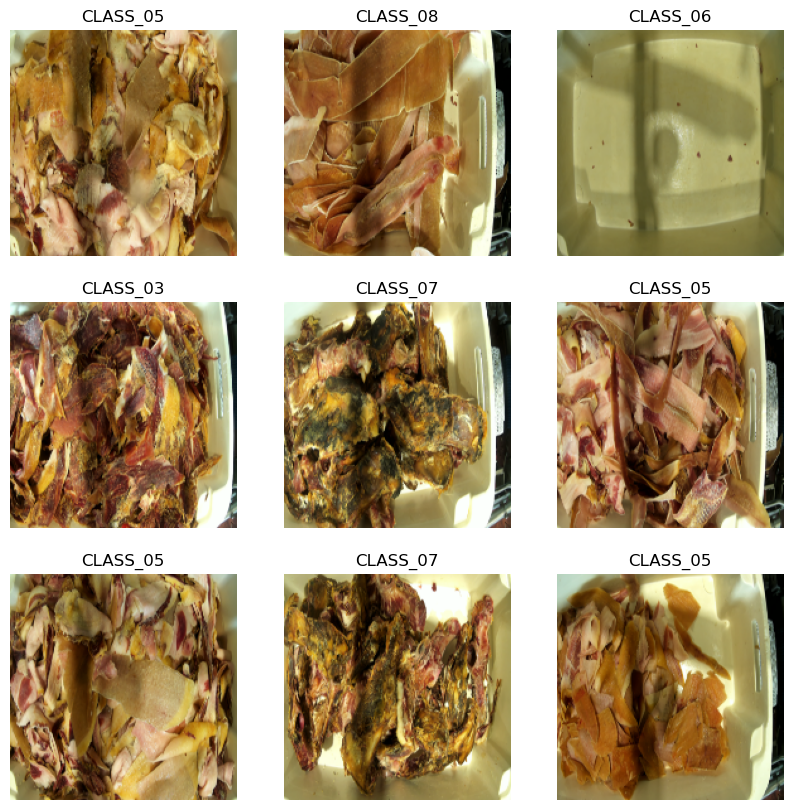

In [3]:
# Visualización de Imagenes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
# Estandarización de datos en el rango de [0, 1]
normalization_layer = layers.Rescaling(1./255)

normalized_df = train_df.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_df))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9589281


In [5]:
# Creación del modelo
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [7]:
# Entrenamiento del modelo
epochs=10
history = model.fit(
  train_df,
  #validation_data=val_df,
  epochs=epochs
)

Epoch 1/10
52/52 [==============================] - 20s 372ms/step - loss: 1.4252 - accuracy: 0.5597
Epoch 2/10
52/52 [==============================] - 24s 450ms/step - loss: 0.8745 - accuracy: 0.7091
Epoch 3/10
52/52 [==============================] - 23s 431ms/step - loss: 0.6189 - accuracy: 0.7710
Epoch 4/10
52/52 [==============================] - 23s 441ms/step - loss: 0.3713 - accuracy: 0.8653
Epoch 5/10
52/52 [==============================] - 24s 449ms/step - loss: 0.2017 - accuracy: 0.9382
Epoch 6/10
52/52 [==============================] - 24s 448ms/step - loss: 0.1346 - accuracy: 0.9541
Epoch 7/10
52/52 [==============================] - 24s 454ms/step - loss: 0.0745 - accuracy: 0.9804
Epoch 8/10
52/52 [==============================] - 24s 445ms/step - loss: 0.0514 - accuracy: 0.9841
Epoch 9/10
52/52 [==============================] - 23s 437ms/step - loss: 0.1491 - accuracy: 0.9498
Epoch 10/10
52/52 [==============================] - 24s 457ms/step - loss: 0.0723 - accura

In [8]:
# Predición con los datos de test

img = tf.keras.utils.load_img(
    r"C:\Users\AlexanderVargas\Downloads\Proyecto Final\test\CLASS_06\23-CAPTURE_20220425_234738_437.png", target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 103ms/step
This image most likely belongs to CLASS_06 with a 99.95 percent confidence.


In [9]:
# Obtener las etiquetas verdaderas del conjunto de entrenamiento
y_true_train = []  # Aquí se almacenan las etiquetas verdaderas del conjunto de entrenamiento

for x, y in train_df:
    y_true_train.extend(y.numpy())

# Calcular las predicciones del modelo en el conjunto de entrenamiento
y_pred_train = model.predict(train_df)
y_pred_train = np.argmax(y_pred_train, axis=1)

# Calcular la matriz de confusión para el conjunto de entrenamiento y muéstrala si lo deseas
cm_train = confusion_matrix(y_true_train, y_pred_train)
print("Matriz de Confusión (Conjunto de Entrenamiento):")
print(cm_train)

52/52 [==============================] - 5s 88ms/step
Matriz de Confusión (Conjunto de Entrenamiento):
[[  2   2   6  40   2   8   2]
 [  7  29  13 130   6  16  12]
 [  4   9   4  68   1  14   5]
 [ 38 114  60 562  23 118  34]
 [  3   3   1  22   0   7   1]
 [  4  31  17 111   4  32   5]
 [  5  10   3  32   0   9   4]]


In [10]:
# Obtener las etiquetas verdaderas del conjunto de prueba
y_true_test = []  # Aquí se almacenan las etiquetas verdaderas del conjunto de prueba

for x, y in test_df:
    y_true_test.extend(y.numpy())

# Calcular las predicciones del modelo en el conjunto de prueba
y_pred_test = model.predict(test_df)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Calcular la matriz de confusión para el conjunto de prueba y muéstrala si lo deseas
cm_test = confusion_matrix(y_true_test, y_pred_test)
print("Matriz de Confusión (Conjunto de Prueba):")
print(cm_test)

26/26 [==============================] - 2s 84ms/step
Matriz de Confusión (Conjunto de Prueba):
[[  4   2   4  30   0   7   1]
 [  5   7   4  60   1  15   5]
 [  3   1   3  32   2   3   1]
 [ 27  36  15 297  10  55  19]
 [  1   2   0  14   0   2   0]
 [  6   7   8  76   2  14   1]
 [  4   2   3  16   0   2   0]]
